In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import numpy as np
import datashader as ds

def clean_df(path: str):
    df = pd.read_csv(path)
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.strip()
    calm = df.iloc[0][df.columns[1]]
    df.loc[0, df.columns[1]] = 0
    df.loc[0, df.columns[0]] = "355-365"
    df = df.set_index("Direction")
    df.loc["0-359", df.columns[0]] = calm
    for col in df.columns:
        mask = df[col] == ''
        df.loc[mask, col] = 0
        df[col] = df[col].astype(float).fillna(0)
    col_names = {col: col if "calm" not in col.lower() else 'Calm' for col in df.columns}
    df = df.rename(columns=col_names).reset_index()
    return df

def run(
        wind_rose_data: pd.DataFrame,
        n_muzzles: int,
        muzzle_velocity: float,
        height: float,
        g: float,
        n_max: int,
        speed_stdev: float,
        angle_stdev: float
):
    speeds_mph = np.array([
        [0,2],
        [2,5],
        [5,7],
        [7,10],
        [10,15],
        [15,20],
        [20,30]
    ]) # mph
    speeds = speeds_mph * 5280 / 3600 # ft/s

    muzzle_azimuths = np.linspace(0, 360, n_muzzles, endpoint=False)
    fall_time = np.sqrt(2 * height / g)

    wind_rose_data["Calm"] = wind_rose_data["Calm"].fillna(0)
    wind_rose_data = wind_rose_data.set_index("Direction")

    wind_rose_data =  wind_rose_data / wind_rose_data.sum().sum()
    init_wind_angle = wind_rose_data.index.str.strip().str.split('-').str[0].astype(int)
    init_wind_angle = (-init_wind_angle+360+90) % 360
    # final_wind_angle = wind_rose_data.index.str.strip().str.split('-').str[1].astype(int)+1
    # final_wind_angle = (-final_wind_angle+360+90) % 360
    final_wind_angle = init_wind_angle + 10
    init_wind_speed = speeds[:,0]
    final_wind_speed = speeds[:,-1]
    # init_wind_angle.shape, init_wind_speed.shape
    densities = wind_rose_data.values
    x = []
    y = []
    for i in range(densities.shape[0]):
        for j in range(densities.shape[1]):
            density = densities[i,j] 
            n_pts = int(density *n_max)
            low_wind_speed = init_wind_speed[j]
            high_wind_speed = final_wind_speed[j]
            low_wind_angle = init_wind_angle[i]+180
            high_wind_angle = final_wind_angle[i]+180
            if i == len(densities)-1:
                low_wind_angle = 0
                high_wind_angle = 360
            # wind_speed = np.random.uniform(low_wind_speed, high_wind_speed, n_pts)
            # wind_angle = np.random.uniform(low_wind_angle, high_wind_angle, n_pts)
            wind_speed = np.random.normal((low_wind_speed + high_wind_speed) / 2, (high_wind_speed - low_wind_speed) / speed_stdev, n_pts)
            wind_angle = np.random.normal((low_wind_angle + high_wind_angle) / 2, (high_wind_angle - low_wind_angle) / angle_stdev, n_pts)
            for k in range(n_muzzles):
                azimuth = muzzle_azimuths[k]
                muzzle_x_velo = np.cos(np.deg2rad(azimuth)) * muzzle_velocity
                muzzle_y_velo = np.sin(np.deg2rad(azimuth)) * muzzle_velocity
                wind_x_velo = np.cos(np.deg2rad(wind_angle)) * wind_speed
                wind_y_velo = np.sin(np.deg2rad(wind_angle)) * wind_speed
                x_velo = wind_x_velo + muzzle_x_velo
                y_velo = wind_y_velo + muzzle_y_velo
                final_x = x_velo * fall_time
                final_y = y_velo * fall_time
                x.append(final_x)
                y.append(final_y)
                # plt.scatter(final_x, final_y, s=s, color="black", alpha=alpha)
    return np.concatenate(x).flatten(), np.concatenate(y).flatten()


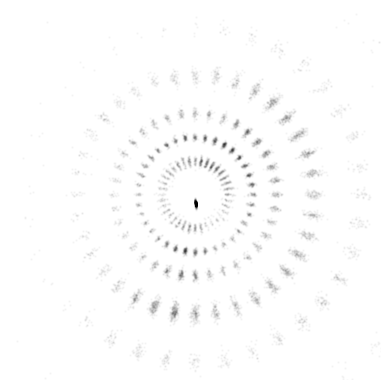

In [132]:
n_muzzles = 1
muzzle_velocity = 0 # ft/s
height = 50 # ft
g = 32.2 # ft/s^2
n_max = 10000
speed_stdev = 10
angle_stdev = 10
bounds = 50
alpha = 0.025
s = 0.75

df = clean_df('eo-wind-data-october.csv')
x, y = run(df, n_muzzles, muzzle_velocity, height, g, n_max, speed_stdev, angle_stdev)
plt.scatter(x, y, s=s, color="black", alpha=alpha)
plt.xlim(-bounds, bounds)
plt.ylim(-bounds, bounds)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

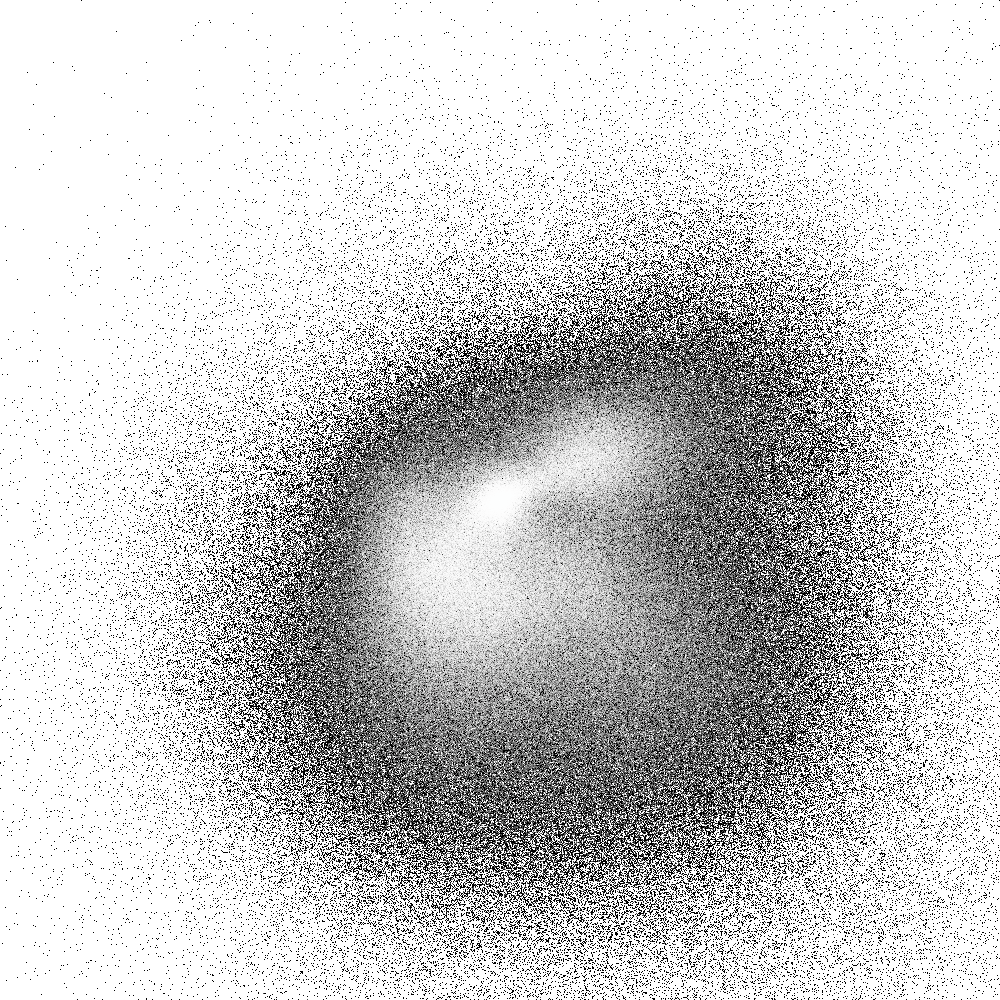

In [71]:
imgs[-1]

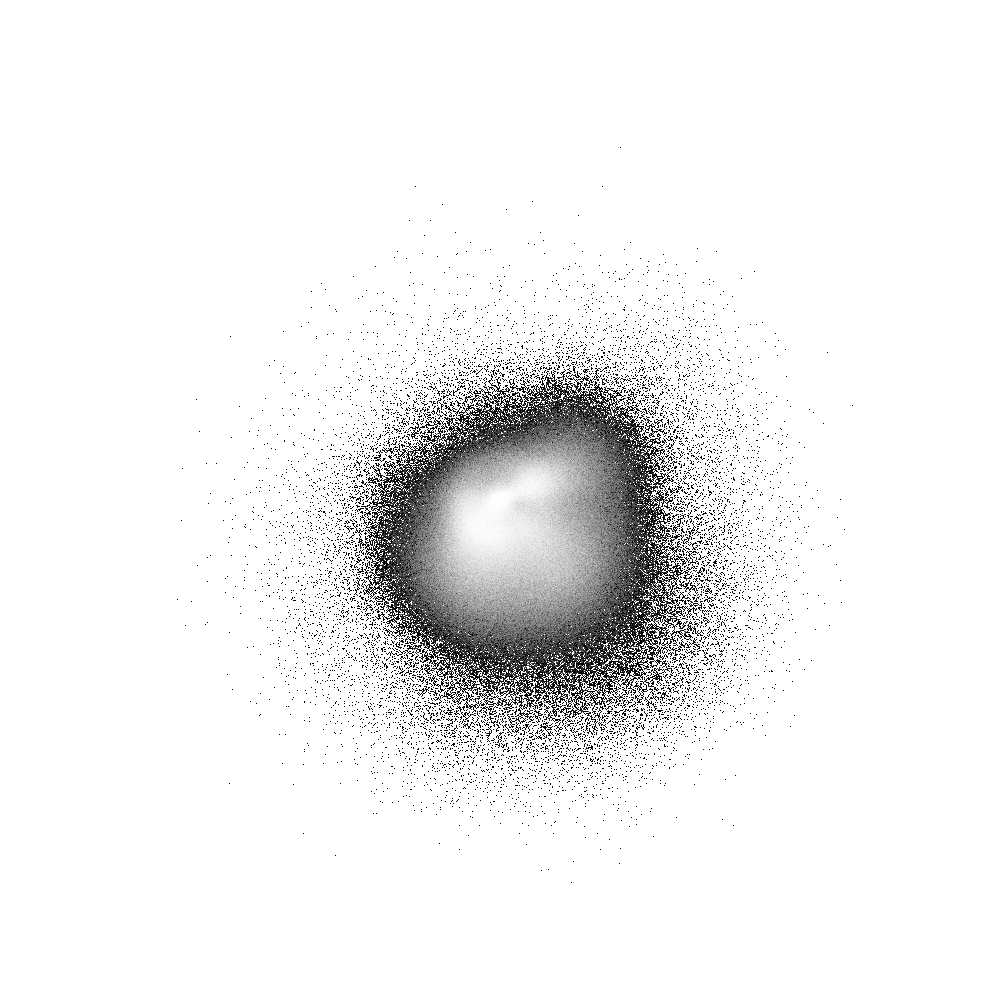

In [70]:
imgs[0]

In [169]:
from datashader.utils import export_image
from pathlib import Path
n_muzzles = 1
muzzle_velocity = 0 # ft/s
height = 50 # ft
g = 32.2 # ft/s^2
n_max = 4000000
speed_stdev = 1
angle_stdev = 1
cmap = cc.fire
# cmap = cc.kbc
# cmap = cc.gray
bounds = 600

imgs = []
for (n_muzzles, muzzle_velocity) in [(24,5), (24, 10), (24,20),(24,25),(24,35)]:
    for m,month in enumerate(["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december","annual"]):
        for i,height in enumerate([50, 100, 250, 400, 800]):
            df = clean_df(f'eo-wind-data-{month}.csv')
            x, y = run(df, n_muzzles, muzzle_velocity, height, g, n_max, speed_stdev, angle_stdev)

            # height = 50
            # muzzle_velocity = 0
            # xx, yy = run(df, n_muzzles, muzzle_velocity, height, g, n_max, speed_stdev, angle_stdev)
            # x = np.concatenate([x, xx]).flatten()
            # y = np.concatenate([y, yy]).flatten()

            cvs = ds.Canvas(plot_width=1000, plot_height=1000, x_range=(-bounds,bounds), y_range=(-bounds,bounds))
            agg = cvs.points(pd.DataFrame({"x": x, "y": y}), 'x', 'y')
            img = ds.tf.shade(agg, cmap=cmap, how='eq_hist')
            imgs.append(img)

            folder = Path('eo-images-v2') / f"{n_muzzles:02d}" / f"{muzzle_velocity:02d}" / f"{m:02d}_{month}"
            folder.mkdir(parents=True, exist_ok=True)
            export_image(img, (folder / f'img_{height:03d}').as_posix(), fmt=".png")
            

    imgs[0]

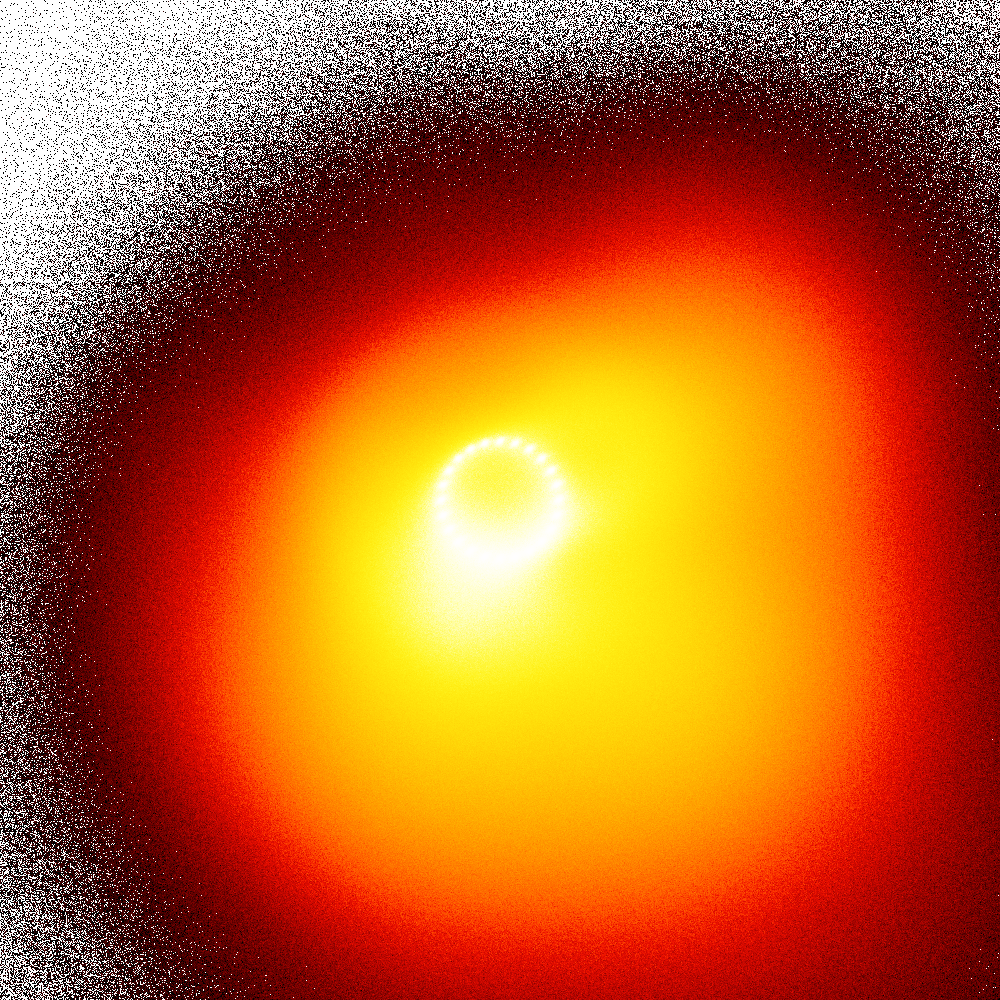

In [92]:
imgs[-1]

In [148]:

n_muzzles = 1
muzzle_velocity = 0 # ft/s
height = 50 # ft
g = 32.2 # ft/s^2
n_max = 1000000
speed_stdev = 1
angle_stdev = 1
cmap = cc.fire
# cmap = cc.kbc
cmap = cc.gray
bounds = 100

df = clean_df('eo-wind-data-july.csv')
x, y = run(df, n_muzzles, muzzle_velocity, height, g, n_max, speed_stdev, angle_stdev)
# height = 50
# muzzle_velocity = 0
# xx, yy = run(df, n_muzzles, muzzle_velocity, height, g, n_max, speed_stdev, angle_stdev)
# x = np.concatenate([x, xx]).flatten()
# y = np.concatenate([y, yy]).flatten()

cvs = ds.Canvas(plot_width=1000, plot_height=1000, x_range=(-bounds,bounds), y_range=(-bounds,bounds))
agg = cvs.points(pd.DataFrame({"x": x, "y": y}), 'x', 'y')
img = ds.tf.shade(agg, cmap=cmap, how='eq_hist')
img

AttributeError: 'Int64Index' object has no attribute 'iloc'

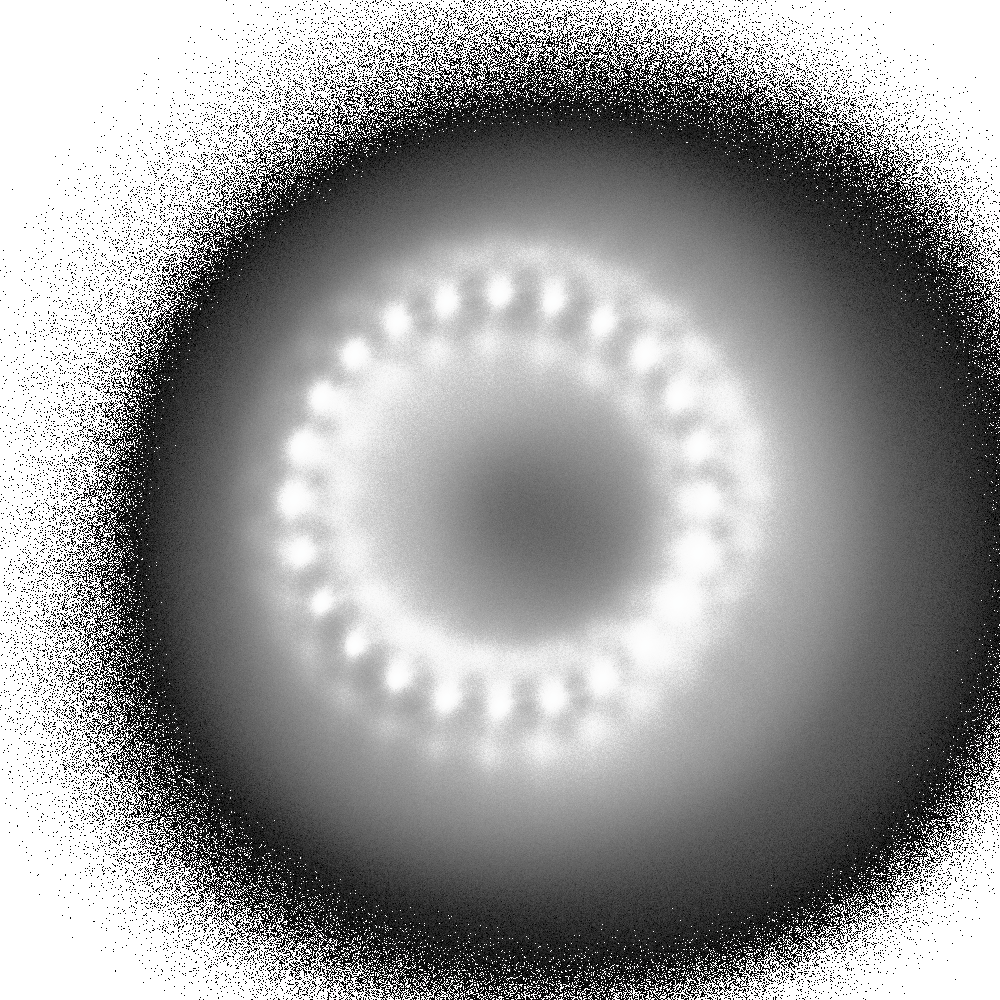

In [168]:
n_muzzles = 24
muzzle_velocity = 35
height = 800
n_max = 4000000
speed_stdev = 1.5
angle_stdev = 1.5
bounds=600
df = clean_df('eo-wind-data-february.csv')
x, y = run(df, n_muzzles, muzzle_velocity, height, g, n_max, speed_stdev, angle_stdev)

cvs = ds.Canvas(plot_width=1000, plot_height=1000, x_range=(-bounds,bounds), y_range=(-bounds,bounds))
agg = cvs.points(pd.DataFrame({"x": x, "y": y}), 'x', 'y')
img = ds.tf.shade(agg, cmap=cmap, how='eq_hist')
img